<a href="https://colab.research.google.com/github/iacopoooo/Tesi/blob/main/Colab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trovate 7940 sequenze. Vocabolario di 20 eventi.
Distribuzione classi: Normali=7627, Anomale=313
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 0.9712 - loss: 0.7374 - precision: 0.7426 - recall: 0.1824 - val_accuracy: 0.9748 - val_loss: 0.3292 - val_precision: 1.0000 - val_recall: 0.3651
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.9680 - loss: 0.6587 - precision: 0.7551 - recall: 0.3103 - val_accuracy: 0.9748 - val_loss: 0.2220 - val_precision: 1.0000 - val_recall: 0.3651
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.9792 - loss: 0.5643 - precision: 0.9850 - recall: 0.3903 - val_accuracy: 0.9748 - val_loss: 0.2567 - val_precision: 1.0000 - val_recall: 0.3651
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.9777 - loss: 0.5873 - precision: 0.9798 - recall: 0.3858 - val_accuracy: 0.9748 - val_loss: 0.2576 - val_precision: 1.0000 - val_recall: 0.3651
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 255ms/step - accuracy: 0.9790 - loss: 0.5430 - precision: 0.9888 - recall: 0.4555 - val_accuracy: 0.9754 - val_loss

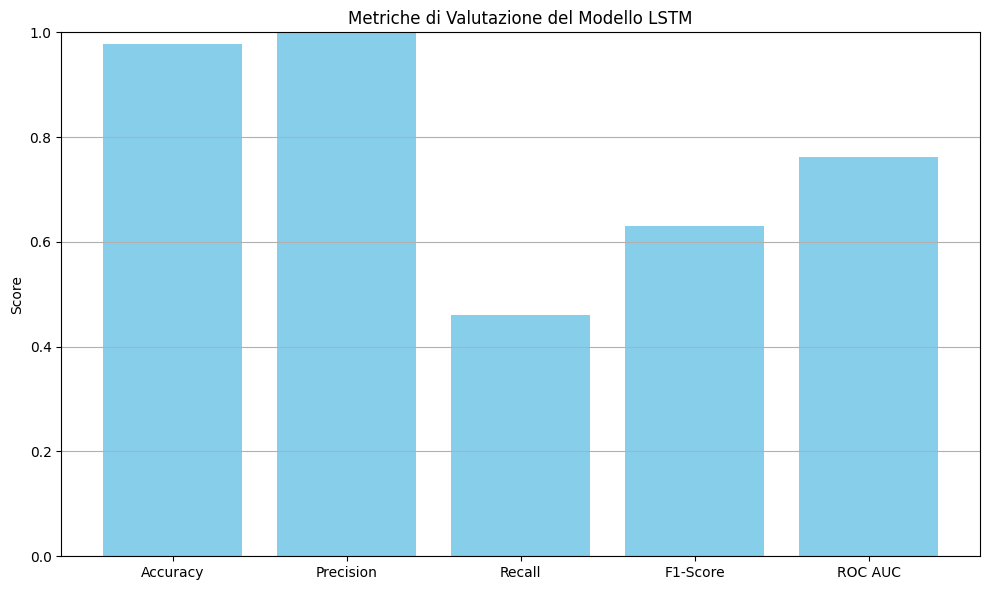

In [2]:

import pandas as pd
import numpy as np
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import re

# --- 1. Caricamento file ---
log_file = '/content/drive/MyDrive/HDFS_100k.log_structured.csv'
label_file = '/content/drive/MyDrive/anomaly_label.csv'

df_logs = pd.read_csv(log_file)
df_labels = pd.read_csv(label_file)

# --- 2. Parsing dei log ---
log_data = defaultdict(list)
for _, row in df_logs.iterrows():
    content = row["Content"]
    event_id = row["EventId"]
    match = re.search(r'blk_-?\d+', content)
    if match:
        blk_id = match.group(0)
        log_data[blk_id].append(event_id)

# --- 3. Etichette ---
label_dict = dict(zip(df_labels['BlockId'], df_labels['Label'].apply(lambda x: 1 if x == 'Anomaly' else 0)))

# --- 4. Costruzione vocabolario ---
all_events = set(e for seq in log_data.values() for e in seq)
event_vocab = {e: i + 1 for i, e in enumerate(sorted(all_events))}  # +1 per padding
vocab_size = len(event_vocab) + 1
max_seq_length = 50

# --- 5. Sequenze numeriche e label ---
sequences = []
sequence_labels = []
for blk_id, events in log_data.items():
    if blk_id in label_dict:
        numeric_seq = [event_vocab[e] for e in events]
        sequences.append(numeric_seq)
        sequence_labels.append(label_dict[blk_id])

X = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')
y = np.array(sequence_labels)

print(f"Trovate {len(X)} sequenze. Vocabolario di {vocab_size} eventi.")
print(f"Distribuzione classi: Normali={sum(y==0)}, Anomale={sum(y==1)}")

# --- 6. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 7. Modello LSTM bidirezionale ---
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_seq_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# --- 8. Addestramento ---
model_lstm.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight={0: 1, 1: 10}
)

# --- 9. Valutazione ---
y_pred_prob = model_lstm.predict(X_test).ravel()
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("\nAccuracy:", accuracy_score(y_test, y_pred_class))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcolo metriche
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
accuracy = accuracy_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Creazione barplot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title('Metriche di Valutazione del Modello LSTM')
plt.ylabel('Score')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
